In [1]:
import threading
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.coordinator.control_module import get_control_module
from vent.coordinator.common.message import SensorValues, ControlSettings, Alarm, AlarmSeverity, ControlSettingName

## First, wrap the controller in a thread

In [2]:
class ControllerThread(threading.Thread):
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID        = threadID
        self.name            = name
        self.counter         = counter
        self.ContollInstance = get_control_module(sim_mode=True)

    def run(self):
        while self.counter:
            self.ContollInstance.run()             # run a contol update 
            self.ContollInstance.update_alarms()   # run an alarm update
            time.sleep(.01)             # sleep 10ms
            self.counter -= 1

    def set_controls(self, command):
        self.ContollInstance.set_controls(command)
        
    def get_sensor_values(self):
        # returns SensorValues, include a timestamp and loop counter
        sv = self.ContollInstance.get_sensors_values()
        sv.loop_counter = self.counter
        return sv

    def heartbeat(self):
        print("%s: %s" % (self.name, time.ctime(time.time())))
        print("Internal counter = " + str(self.counter)+'.\n')


# Set the controls

In [3]:
c1 = ControlSettings(name=ControlSettingName.PIP, value=22, min_value=20, \
                          max_value=24, timestamp=time.time())

c2 = ControlSettings(name=ControlSettingName.PIP_TIME, value=0.3, min_value=0.1, \
                          max_value=0.6, timestamp=time.time())

c3 = ControlSettings(name=ControlSettingName.PEEP, value=5, min_value=4, \
                          max_value=6, timestamp=time.time())

c4 = ControlSettings(name=ControlSettingName.BREATHS_PER_MINUTE, value=17, \
                          min_value=16, max_value=19, timestamp=time.time())

c5 = ControlSettings(name=ControlSettingName.INSPIRATION_TIME_SEC, value=2.0, 
                          min_value=1.0, max_value=3.0, timestamp=time.time())

In [4]:
runtime = 60 # run this for 30 seconds
thread1 = ControllerThread(1, "Controller-1", runtime/0.01) #5sec in 10ms steps

for command in [c1,c2,c3,c4,c5]:
    thread1.set_controls(command)

# And this is to get the data

In [5]:
sample_times = 0.05 #get a sample every 50ms

thread1.start()  # Start Controller

ls = []
tt = []
for t in np.arange(0,runtime,sample_times):
    
    if t%5==0:  # ask for a heartbeat from thread two seconds
        thread1.heartbeat()
    
    if t>15:    #after 15 sec, set PEEP to 10
        command = ControlSettings(name=ControlSettingName.PEEP, value=10, min_value=9, max_value=12, timestamp=time.time())
        thread1.set_controls(command)
        command = ControlSettings(name=ControlSettingName.PIP, value=16, min_value=15, max_value=17, timestamp=time.time())
        thread1.set_controls(command)
        
    if t>35:    #after 15 sec, set PEEP to 10
        command = ControlSettings(name=ControlSettingName.PEEP, value=7, min_value=5, max_value=9, timestamp=time.time())
        thread1.set_controls(command)
        command = ControlSettings(name=ControlSettingName.PIP, value=20, min_value=18, max_value=22, timestamp=time.time())
        thread1.set_controls(command)
        command = ControlSettings(name=ControlSettingName.BREATHS_PER_MINUTE, value=10, min_value=8, max_value=11, timestamp=time.time()) 
        thread1.set_controls(command)
        
    vals = thread1.get_sensor_values()
    ls.append(vals)
    tt.append(time.time())
    
    time.sleep(0.05)

Controller-1: Sun Apr 19 18:40:57 2020
Internal counter = 6000.0.

Controller-1: Sun Apr 19 18:41:02 2020
Internal counter = 5554.0.

Controller-1: Sun Apr 19 18:41:07 2020
Internal counter = 5131.0.

Controller-1: Sun Apr 19 18:41:12 2020
Internal counter = 4708.0.

PIP: 15 < 22.134374395139798 < 17  violated.
PEEP: 9 < 5.342040547290958 < 12  violated.
Controller-1: Sun Apr 19 18:41:18 2020
Internal counter = 4275.0.

Controller-1: Sun Apr 19 18:41:23 2020
Internal counter = 3846.0.

Controller-1: Sun Apr 19 18:41:28 2020
Internal counter = 3421.0.

Controller-1: Sun Apr 19 18:41:33 2020
Internal counter = 2995.0.

PIP: 18 < 16.268396121931524 < 22  violated.
PEEP: 5 < 10.180175608448911 < 9  violated.
BREATHS_PER_MINUTE: 8 < 17.037622428725122 < 11  violated.
Controller-1: Sun Apr 19 18:41:39 2020
Internal counter = 2571.0.

Controller-1: Sun Apr 19 18:41:44 2020
Internal counter = 2152.0.

Controller-1: Sun Apr 19 18:41:49 2020
Internal counter = 1730.0.

Controller-1: Sun Apr 19 1

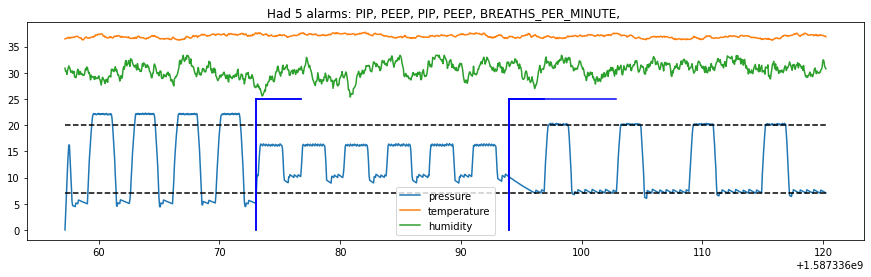

In [24]:
pl.rcParams['figure.figsize'] = [15, 4]

pip = thread1.ContollInstance.Controller.PIP
peep = thread1.ContollInstance.Controller.PEEP

pl.plot(tt, [s.pressure for s in ls], label = 'pressure')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

for alarm in thread1.ContollInstance.get_active_alarms():
    pl.plot([alarm.alarm_start_time, alarm.alarm_start_time], [0,25], 'r-')
for alarm in thread1.ContollInstance.get_logged_alarms():
    pl.plot([alarm.alarm_start_time, alarm.alarm_start_time], [0,25], 'b-')
    pl.plot([alarm.alarm_start_time, alarm.alarm_end_time],  [25,25], 'b-')

s = "Had " + str(len(thread1.ContollInstance.get_alarms())) + " alarms: "
for alarm in thread1.ContollInstance.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()

# Controller keeps a dictionary of all breath-cycle waveforms

Here is how they look like

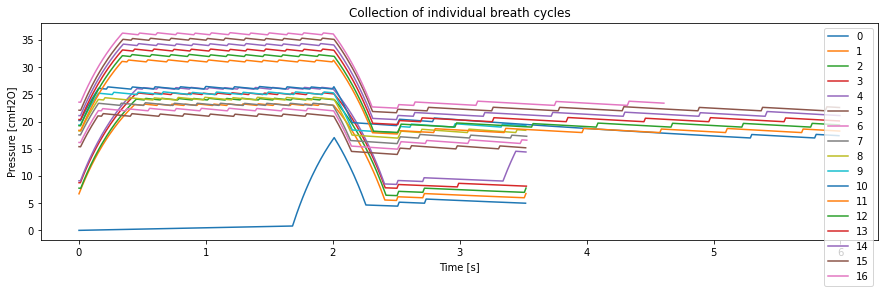

In [22]:
for k in thread1.ContollInstance.Controller.cycle_waveforms.keys():
    array = thread1.ContollInstance.Controller.cycle_waveforms[k]
    phase = array[:,0]
    pressure = array[:,1]
    pl.plot(phase, pressure+k, label=k)
pl.legend()
pl.title("Collection of individual breath cycles")
pl.xlabel("Time [s]")
pl.ylabel("Pressure [cmH2O]");

# And this is how PEEP/PIP etc. are heuristically measured from the waveform

In [ ]:
k = 17

array = thread1.ContollInstance.Controller.cycle_waveforms[k]
phase = array[:,0]
pressure = array[:,1]

In [25]:
PEEP = np.percentile(pressure,20)  #the 20 and 80 percentiles are arbitrary
PIP  = np.percentile(pressure,80)

last_PIP = phase[ np.max(np.where(pressure>PIP)) ]
first_PIP = phase[ np.min(np.where(pressure>PIP)) ]

first_PEEP = phase[ np.min(np.where(np.logical_and(pressure<PEEP, phase > 1))) ]
last_PEEP = phase[-1]

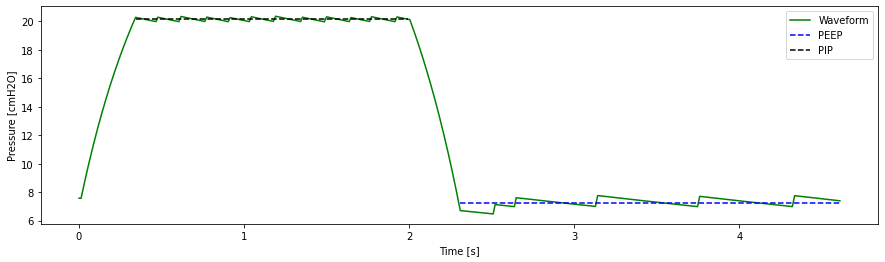

In [26]:
pl.plot(phase, pressure, 'g-', label="Waveform")
pl.plot([first_PEEP, last_PEEP],[PEEP,PEEP],'b--', label="PEEP")
pl.plot([first_PIP, last_PIP],[PIP,PIP],'k--', label = "PIP")
pl.xlabel("Time [s]")
pl.ylabel("Pressure [cmH2O]")
pl.legend();